Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 30, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_attention                │ (None, 64)             │         2,113 │
│ (SimpleAttention)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 10, 3)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,471 (83.87 KB)

 Trainable params: 21,471 (83.87 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 0.1495 - val_loss: 0.0234
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0103 - val_loss: 0.0178
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0088 - val_loss: 0.0101
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0062 - val_loss: 0.0178
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0049 - val_loss: 0.0074
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0044 - val_loss: 0.0062
Epoch 9/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0044 - val_loss: 0.0055
Epoch 10/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0044 - val_loss: 0.0059
Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.1235 - val_loss: 0.0186
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 3

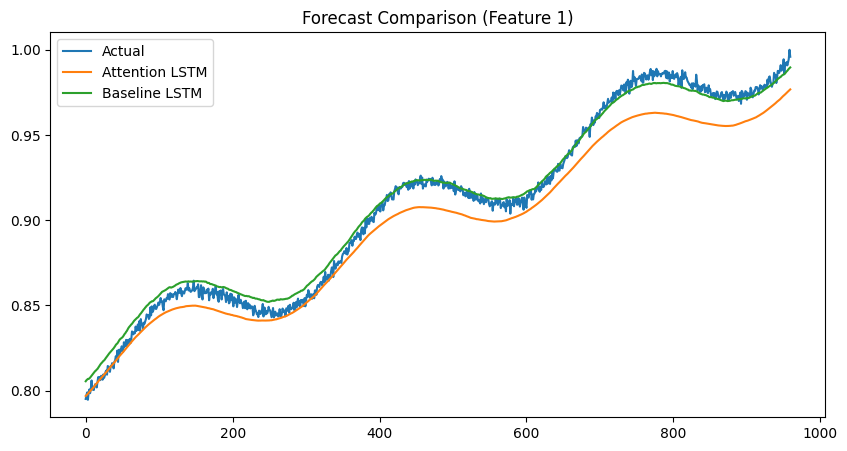

Attention LSTM - RMSE: 0.015648758322552966 MAE: 0.012080275214567294
Baseline LSTM  - RMSE: 0.016075672688944827 MAE: 0.012285770237946463


In [2]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# 1. Generate synthetic time series data
np.random.seed(42)
timesteps = 5000
features = 3
time = np.arange(timesteps)
data = []
for i in range(features):
    series = np.sin(0.02 * time + i) + 0.01 * time + np.random.normal(0, 0.1, timesteps)
    data.append(series)
df = pd.DataFrame(np.array(data).T, columns=[f'f{i+1}' for i in range(features)])

# 2. Preprocess data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)

def create_sequences(data, input_steps=30, output_steps=10):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps):
        X.append(data[i:i+input_steps])
        y.append(data[i+input_steps:i+input_steps+output_steps])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled)
X_train, y_train = X[:4000], y[:4000]
X_test, y_test = X[4000:], y[4000:]

# 3. Simple Attention Layer (FIXED VERSION)
class SimpleAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(SimpleAttention, self).__init__(**kwargs)
        self.W = tf.keras.layers.Dense(units, activation='tanh')
        self.V = tf.keras.layers.Dense(1)

    def call(self, values):
        # values: (batch, timesteps, features)
        score = self.V(self.W(values))           # (batch, timesteps, 1)
        weights = tf.nn.softmax(score, axis=1)   # (batch, timesteps, 1)
        context = tf.reduce_sum(weights * values, axis=1)  # (batch, features)
        return context

# 4. Attention-based LSTM model
input_steps = X_train.shape[1]
feature_dim = X_train.shape[2]
output_steps = y_train.shape[1]

inputs = tf.keras.layers.Input(shape=(input_steps, feature_dim))
lstm_out = tf.keras.layers.LSTM(64, return_sequences=True)(inputs)
attention = SimpleAttention(32)(lstm_out)
flat = tf.keras.layers.Dense(feature_dim * output_steps)(attention)
outputs = tf.keras.layers.Reshape((output_steps, feature_dim))(flat)

model = tf.keras.models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mae')
model.summary()
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# 5. Baseline LSTM model (no attention)
baseline = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(input_steps, feature_dim)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(feature_dim * output_steps),
    tf.keras.layers.Reshape((output_steps, feature_dim))
])
baseline.compile(optimizer='adam', loss='mae')
baseline.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# 6. Predictions
y_pred_attn = model.predict(X_test)
y_pred_base = baseline.predict(X_test)

# 7. Visualization
plt.figure(figsize=(10, 5))
plt.plot(y_test[:, -1, 0], label='Actual')
plt.plot(y_pred_attn[:, -1, 0], label='Attention LSTM')
plt.plot(y_pred_base[:, -1, 0], label='Baseline LSTM')
plt.legend()
plt.title('Forecast Comparison (Feature 1)')
plt.show()

# 8. Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

def get_metrics(true, pred):
    true = true.reshape(-1)
    pred = pred.reshape(-1)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    return rmse, mae

rmse_attn, mae_attn = get_metrics(y_test, y_pred_attn)
rmse_base, mae_base = get_metrics(y_test, y_pred_base)

print("Attention LSTM - RMSE:", rmse_attn, "MAE:", mae_attn)
print("Baseline LSTM  - RMSE:", rmse_base, "MAE:", mae_base)
